# Coral Bleaching Analysis
References: 
    1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8776938/
    2. https://www.nature.com/articles/s41597-022-01121-y

For the analysis, I found the database from the source (1) and planned out how to retrieve the data needed for our project and learned all the tables that would help. I realized the db was written in sql and I would have to write extensive queries and clean the data to find some corelations between overfishing, algae bloom and coral bleaching. 

## Libraries needed for py imports :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


## Functions to retrieve data from the db: sql_get and print_stats
sql_get - makes a connection to the db
print_stats - quereies will be written here and returned

In [3]:
def sql_get( dbCursor, *query_args ):
    # fetch the query from the database and store in row
    # if just query and no vars
    if len(query_args) == 1 :
        dbCursor.execute(query_args[0])
    else: # with query and vars
        dbCursor.execute(query_args[0], query_args[1:])
    row = dbCursor.fetchall();
    # return the [0][0] element of the query result - used when the query return is a singelton
    if (row != None) & ( len(row) == 1 ):
        if ( len(row[0]) == 1 ):
            return row[0][0]
    # else return the list of tuples of the result        
    return row

In [4]:
def print_stats(dbConn):
     # connection to db
    dbCursor = dbConn.cursor()
    hell = sql_get ( dbCursor, "SELECT COUNT(*) FROM Bleaching_tbl;")
    print("Total Rows:", hell)

    
    # Kumagai data has severity code 0,1,2,3
    #   (-1, '% unknown', 'T'), (0, 'No Bleaching', 'T'), (1, 'Mild (1-10% Bleached)', 'T'), (2, 'Moderate (11-50% Bleached)', 'T'), (3, 'Severe (>50% Bleached)', 'T') from severity_code_LUT
    # Donner data has severity code -1,0,1,2,3 and percent_bleached (some of them are None)
    #   (-1, '% unknown', 'T'), (0, 'No Bleaching', 'T'), (1, 'Mild (1-10% Bleached)', 'T'), (2, 'Moderate (11-50% Bleached)', 'T'), (3, 'Severe (>50% Bleached)', 'T') from severity_code_LUT

    #  print Bleaching_tbl columns 
    column_names =  sql_get ( dbCursor, "PRAGMA table_info(Environmental_tbl);" )
    # print(column_names)

    # print ( "OCEAN: ", sql_get ( dbCursor, "SELECT * from Data_Source_LUT;" ) )

    Donner = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, Data_Source_LUT.Data_Source, Bleaching_tbl.Severity_Code,\
                                Environmental_tbl.ClimSST, Environmental_tbl.Windspeed, Environmental_tbl.SSTA, Environmental_tbl.SSTA_DHW, Environmental_tbl.TSA, Environmental_tbl.TSA_DHW\
                                FROM Data_Source_LUT\
                                JOIN Site_Info_tbl ON Site_Info_tbl.Data_Source = Data_Source_LUT.Data_Source_ID\
                                JOIN Ocean_Name_LUT ON Site_Info_tbl.Ocean_Name = Ocean_Name_LUT.Ocean_ID\
                                JOIN Country_Name_LUT ON Site_Info_tbl.Country_Name = Country_Name_LUT.Country_ID\
                                JOIN Sample_Event_tbl ON Sample_Event_tbl.Site_ID = Site_Info_tbl.Site_ID\
                                JOIN Bleaching_tbl ON Bleaching_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                JOIN Environmental_tbl ON Environmental_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                WHERE Date_Year BETWEEN 1980 AND 2020\
                                AND Data_Source_LUT.Data_Source like '%Donner%'\
                                AND Ocean_Name_LUT.Ocean_Name like '%Atlantic%';" )
    # print ( "Donner: ", Donner )    
    # donnertemp = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, Data_Source_LUT.Data_Source, Environmental_tbl.SSTA\
    #                             FROM Data_Source_LUT\
    #                             JOIN Site_Info_tbl ON Site_Info_tbl.Data_Source = Data_Source_LUT.Data_Source_ID\
    #                             JOIN Ocean_Name_LUT ON Site_Info_tbl.Ocean_Name = Ocean_Name_LUT.Ocean_ID\
    #                             JOIN Country_Name_LUT ON Site_Info_tbl.Country_Name = Country_Name_LUT.Country_ID\
    #                             JOIN Sample_Event_tbl ON Sample_Event_tbl.Site_ID = Site_Info_tbl.Site_ID\
    #                             JOIN Environmental_tbl ON Environmental_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
    #                             WHERE Date_Year BETWEEN 1980 AND 2020\
    #                             AND Data_Source_LUT.Data_Source like '%Donner%'\
    #                             AND Ocean_Name_LUT.Ocean_Name like '%Atlantic%' LIMIT 5;" )
    # print ( "Donner: ", donnertemp )

    # AGRRA data has percent_bleached

    # FRRP data has percent_bleached - Atlantic Ocean data
    # .csv has Bleaching levels
    #   P = Pale (Tissue color is lighter than normal)
    #   PB = Partially Bleached (Portions of the coral have a complete loss of color)
    #   (BL) = Bleached (100% of coral tissue has lost its color and appears white)

    #  print Bleaching_tbl columns 
    # column_names =  sql_get ( dbCursor, "PRAGMA table_info(Bleaching_tbl);" )
    # print(column_names)

    # McClanahan data has percent_bleached, Number__Bleached_Colonies, bleach_intensity 
    

    # Safaie data has Bleaching_Prevalence_Score_LUT
    #       ([(0, 'No Bleaching', 'T'), (1, '<= 10% Reef Area Bleached', 'T'), (2, '10-25% Reef Area Bleached', 'T'), (3, '25-50% Reef Area Bleached', 'T'), (4, '>50% Reef Area Bleached', 'T')])
    safaie = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, Data_Source_LUT.Data_Source, Bleaching_tbl.Bleaching_Prevalence_Score,\
                                    Environmental_tbl.ClimSST, Environmental_tbl.Windspeed, Environmental_tbl.SSTA, Environmental_tbl.SSTA_DHW, Environmental_tbl.TSA, Environmental_tbl.TSA_DHW\
                                    FROM Data_Source_LUT\
                                    JOIN Site_Info_tbl ON Site_Info_tbl.Data_Source = Data_Source_LUT.Data_Source_ID\
                                    JOIN Ocean_Name_LUT ON Site_Info_tbl.Ocean_Name = Ocean_Name_LUT.Ocean_ID\
                                    JOIN Country_Name_LUT ON Site_Info_tbl.Country_Name = Country_Name_LUT.Country_ID\
                                    JOIN Sample_Event_tbl ON Sample_Event_tbl.Site_ID = Site_Info_tbl.Site_ID\
                                    JOIN Bleaching_tbl ON Bleaching_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                    JOIN Environmental_tbl ON Environmental_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                    WHERE Date_Year BETWEEN 1980 AND 2020\
                                    AND Data_Source_LUT.Data_Source like '%Safaie%'\
                                    AND Ocean_Name_LUT.Ocean_Name like '%Atlantic%'" )
    

    # safaie = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, Data_Source_LUT.Data_Source, Bleaching_tbl.Severity_Code\

    # all the data can be tied by 
    #   *donner needs to drop -1 values
    #   0 - no bleaching
    #   1 - mild 1-10%
    #   2 - moderate 11-50%
    #   3 - severe >50%

    #  Reef_check should be averaged and classified as above
    #  *AGRRA - percent_bleached should be classified as above
    #  *FRRP should be classified as above. use the .csv file if you want 2005-2022 data. "Bleaching" column and is part of the Atlantic Ocean since florida collected the data?
    #  *McClanahan - percent_bleached should be classified as above
    #  Safaie - Bleaching_Prevalence_Score_LUT should be classified as above

    # get the reef check data from the db specially the S1,S2,S3,S4, ocean, country, year and data source
    reef_check = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, (S1), (S2), (S3), (S4), Data_Source_LUT.Data_Source,\
                                    Environmental_tbl.ClimSST, Environmental_tbl.Windspeed, Environmental_tbl.SSTA, Environmental_tbl.SSTA_DHW, Environmental_tbl.TSA, Environmental_tbl.TSA_DHW\
                                    FROM Data_Source_LUT\
                                    JOIN Site_Info_tbl ON Site_Info_tbl.Data_Source = Data_Source_LUT.Data_Source_ID\
                                    JOIN Ocean_Name_LUT ON Site_Info_tbl.Ocean_Name = Ocean_Name_LUT.Ocean_ID\
                                    JOIN Country_Name_LUT ON Site_Info_tbl.Country_Name = Country_Name_LUT.Country_ID\
                                    JOIN Sample_Event_tbl ON Sample_Event_tbl.Site_ID = Site_Info_tbl.Site_ID\
                                    JOIN Bleaching_tbl ON Bleaching_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                    JOIN Environmental_tbl ON Environmental_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                    WHERE Date_Year BETWEEN 1980 AND 2020\
                                    AND Country_Name_LUT.Country_Name IS NOT NULL\
                                    AND Bleaching_tbl.S1 IS NOT NULL AND Bleaching_tbl.S2 IS NOT NULL AND Bleaching_tbl.S3 IS NOT NULL AND Bleaching_tbl.S4 IS NOT NULL\
                                    AND Bleaching_tbl.Percent_Bleached IS NULL\
                                    AND Data_Source_LUT.Data_Source like 'Reef_Check'\
                                    AND Ocean_Name_LUT.Ocean_Name like '%Atlantic%';")

    # other data sources that are like Donner, etc.
    other_sources = sql_get ( dbCursor, "SELECT Ocean_Name_LUT.Ocean_Name, Country_Name_LUT.Country_Name, Date_Year, Data_Source_LUT.Data_Source, Bleaching_tbl.Percent_Bleached, \
                                Environmental_tbl.ClimSST, Environmental_tbl.Windspeed, Environmental_tbl.SSTA, Environmental_tbl.SSTA_DHW, Environmental_tbl.TSA, Environmental_tbl.TSA_DHW\
                                FROM Data_Source_LUT\
                                JOIN Site_Info_tbl ON Site_Info_tbl.Data_Source = Data_Source_LUT.Data_Source_ID\
                                JOIN Ocean_Name_LUT ON Site_Info_tbl.Ocean_Name = Ocean_Name_LUT.Ocean_ID\
                                JOIN Country_Name_LUT ON Site_Info_tbl.Country_Name = Country_Name_LUT.Country_ID\
                                JOIN Sample_Event_tbl ON Sample_Event_tbl.Site_ID = Site_Info_tbl.Site_ID\
                                JOIN Bleaching_tbl ON Bleaching_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                JOIN Environmental_tbl ON Environmental_tbl.Sample_ID = Sample_Event_tbl.Sample_ID\
                                WHERE Date_Year BETWEEN 1980 AND 2020\
                                AND Country_Name_LUT.Country_Name IS NOT NULL\
                                AND Bleaching_tbl.S1 IS NULL AND Bleaching_tbl.S2 IS NULL AND Bleaching_tbl.S3 IS NULL AND Bleaching_tbl.S4 IS NULL\
                                AND Bleaching_tbl.Percent_Bleached IS NOT NULL\
                                AND Data_Source_LUT.Data_Source != 'Reef_Check'\
                                AND Data_Source_LUT.Data_Source != 'Donner'\
                                AND Data_Source_LUT.Data_Source != 'Safaie'\
                                AND Ocean_Name_LUT.Ocean_Name like '%Atlantic%';")
    # print(" Valid Data:", other_sources )
    return reef_check, other_sources, Donner, safaie

## Create the connection and retrieve the data:
"main" of the program

In [5]:
######################################################################################################################################################################################################################################################
# sql connection to db and get data that is not reef check
dbConn = sqlite3.connect('Global_Coral_Bleaching.db')
# majority of the data is cleaned and retreived from the db by the print_stats function as specific queries are used for each data source and cleaning
reef_data, other_data, Donner, safaie = print_stats(dbConn)
# close the db connection after getting the data
dbConn.close()

Total Rows: 34846


## Adding the data retrieved from the to pandas dataframes

In [6]:
# reef check data
df = pd.DataFrame(reef_data, columns=['Ocean', 'Country', 'Year', 'S1', 'S2', 'S3', 'S4', 'Data_Source', 'ClimSST', 'Windspeed', 'SSTA', 'SSTA_DHW', 'TSA', 'TSA_DHW'])
print ("Reef Check:", df.shape)

Reef Check: (4154, 14)


In [7]:
# create a dataframe from the data
df2 = pd.DataFrame(other_data, columns=['Ocean', 'Country', 'Year', 'Data_Source', 'Percent_Bleached', 'ClimSST', 'Windspeed', 'SSTA', 'SSTA_DHW', 'TSA', 'TSA_DHW'])
print ("Other Sources:", df2.shape)

Other Sources: (5256, 11)


In [8]:
# Donner data
# Donner data has severity code -1,0,1,2,3 and percent_bleached (some of them are None)
#   (-1, '% unknown', 'T'), (0, 'No Bleaching', 'T'), (1, 'Mild (1-10% Bleached)', 'T'), (2, 'Moderate (11-50% Bleached)', 'T'), (3, 'Severe (>50% Bleached)', 'T') from severity_code_LUT
df3 = pd.DataFrame(Donner, columns=['Ocean', 'Country', 'Year', 'Data_Source', 'Severity_Code', 'ClimSST', 'Windspeed', 'SSTA', 'SSTA_DHW', 'TSA', 'TSA_DHW' ])
print ("Donner:", df3.shape)

Donner: (4246, 11)


In [9]:
# Safaie data
df4 = pd.DataFrame(safaie, columns=['Ocean', 'Country', 'Year', 'Data_Source', 'Bleaching_Prevalence_Score_LUT', 'ClimSST', 'Windspeed', 'SSTA', 'SSTA_DHW', 'TSA', 'TSA_DHW' ])
print ("Safaie:", df4.shape)

Safaie: (8, 11)


## Data cleaning

Most of the data retrived from is cleaned because of the sql queries I wrote and specific sources data is retrieved for each case

### NULL values needs to be dropped

In [10]:
######################################################################################################################################################################################
# cleaning data and normalizing it

# check if df, df2, df3, df4 have any null values and if so drop them, although majority of the data is cleaned in the queries by the use of IS NOT NULL
df = df.dropna()
df2 = df2.dropna()
df3 = df3.dropna()
df4 = df4.dropna()


### df:
Reef Check data needs to be normalized since the tables columns S1,S2,S3,S4 are different bleaching percentages by trans intersect areas of each ocean. Averaging out these numbers and making them as one column could be one appraoch

In [11]:
# lets get the average of S1,S2,S3,S4 and add it to a new column Average_bleaching
df['Percent_Bleached'] = df[['S1', 'S2', 'S3', 'S4']].mean(axis=1)

# lets drop S1,S2,S3,S4 and Reef Name columns from df since we calculated the average of the bleaching levels 
df = df.drop(['S1', 'S2', 'S3', 'S4'], axis=1)

### Year column are in strings needs to be converted into integer

In [12]:
# convert the year column to int removing the decimal places
df['Year'] = df['Year'].astype(int)
df2['Year'] = df2['Year'].astype(int)
df3['Year'] = df3['Year'].astype(int)
df4['Year'] = df4['Year'].astype(int)

### Percent bleached column needs to be rounded

In [13]:
# round the percent bleached column to 2 decimal places in df2 and df
df['Percent_Bleached'] = df['Percent_Bleached'].round(2)
df2['Percent_Bleached'] = df2['Percent_Bleached'].round(2)


### Data needs to be normalized to a scale

    0 - 0 ( NO BLEACHING )
    1-10% - 1 ( MILD BLEACHING )
    11-50% - 2 ( MODERATE BLEACHING )
    >50% - 3 ( SEVERE BLEACHING )

In [14]:
# lets create a function to convert the percent bleached column to severity code
def convert_to_severity_code(percent):
    if percent == 0:
        return 0
    elif percent <= 10:
        return 1
    elif percent <= 50:
        return 2
    elif percent > 50:
        return 3
    
# lets apply the function to the percent bleached column
df['Severity_Code'] = df['Percent_Bleached'].apply(convert_to_severity_code)
df2['Severity_Code'] = df2['Percent_Bleached'].apply(convert_to_severity_code)

### Drop the columns that we have weren't normalized

In [15]:
# lets drop the percent bleached column from df and df2
df = df.drop(['Percent_Bleached'], axis=1)
df2 = df2.drop(['Percent_Bleached'], axis=1)

### Drop -1's
df3 have some -1 values from the db, since this data was noramlized to severity code already and -1 represents data wasn't collected for this area

In [16]:
# drop the -1 values from the severity code column
df3 = df3[df3.Severity_Code != -1]

### df4 needs to be normalized to the scale
    0 - 0 ( NO BLEACHING )
    1-10% - 1 ( MILD BLEACHING )
    11-50% - 2 ( MODERATE BLEACHING )
    >50% - 3 ( SEVERE BLEACHING )

In [17]:
# df4 has a column called Bleaching_Prevalence_Score_LUT which is a scale of 0-4
# convert the Bleaching_Prevalence_Score_LUT column to severity code specially if the value is 3 in bleaching_prevalence_score_lut then convert it to 2 in severity code
def convert_to_severity_code2(score):
    if score == 0:
        return 0
    elif score == 1:
        return 1
    elif score == 2:
        return 2
    elif score == 3:
        return 2
    elif score == 4:
        return 3
    
# lets apply the function to the Bleaching_Prevalence_Score_LUT column
df4['Severity_Code'] = df4['Bleaching_Prevalence_Score_LUT'].apply(convert_to_severity_code2)

# lets drop the Bleaching_Prevalence_Score_LUT column from df4
df4 = df4.drop(['Bleaching_Prevalence_Score_LUT'], axis=1)

## Print the cleaned data

In [18]:
print(df.head())
print(df2.head())
print(df3.head())
print(df4.head())

      Ocean   Country  Year Data_Source  ClimSST  Windspeed    SSTA  SSTA_DHW  \
0  Atlantic  Barbados  2005  Reef_Check   299.48        7.0  1.0900      0.00   
1  Atlantic  Barbados  2003  Reef_Check   299.73       10.0  0.0300      0.00   
2  Atlantic  Barbados  2003  Reef_Check   300.62        7.0  0.6000      0.00   
3  Atlantic  Dominica  2018  Reef_Check   299.61        8.0  0.5900      0.00   
4  Atlantic  Dominica  2018  Reef_Check   262.15        8.0  0.5025      0.51   

     TSA  TSA_DHW  Severity_Code  
0 -1.010      0.0              1  
1 -2.420      0.0              1  
2 -1.120      0.0              1  
3 -1.990      0.0              0  
4 -2.115      0.0              0  
      Ocean        Country  Year Data_Source  ClimSST  Windspeed      SSTA  \
0  Atlantic  United States  2015        FRRP   299.33        4.0  0.540000   
1  Atlantic  United States  2008        FRRP   301.67        9.0 -0.920000   
2  Atlantic  United States  2015        FRRP   298.32        2.0  1.5

## Combines all the dataframes
one dataframe (df+df2+df3+df4) and convert the Severity_Code column to integer

In [19]:
#  lets combine the dataframes df, df2, df3, df4 into one dataframe
frames = [df, df2, df3, df4]
df = pd.concat(frames)
df['Severity_Code'] = df['Severity_Code'].astype(int)
# lets sort the year column ascending order
df = df.sort_values(by=['Year'], ascending=True)

# print(df.head(15))

### Group the data by year and the severity code

In [20]:
# group by year and calculate the mean bleaching severity for each year
grouped = df.groupby('Year').agg({'Severity_Code': 'mean', 'SSTA': 'mean', 'ClimSST': 'mean', 'Windspeed': 'mean', 'SSTA_DHW': 'mean', 'TSA': 'mean', 'TSA_DHW': 'mean'}).reset_index()
print(grouped.tail(15))


    Year  Severity_Code      SSTA     ClimSST  Windspeed  SSTA_DHW       TSA  \
17  2005       1.927500  0.384241  288.532164   5.245357  5.010874 -0.409401   
18  2006       1.396313  0.191358  290.836961   5.081633  1.111543 -1.548596   
19  2007       0.971200  0.265689  292.652816   5.793600  2.654951 -0.872056   
20  2008       0.777603  0.083850  293.929106   5.192429  1.758726 -1.032631   
21  2009       1.073668  0.380874  294.111301   4.920063  3.110500 -0.583384   
22  2010       1.133192  0.510271  294.730592   4.934461  6.244446 -1.006034   
23  2011       0.990476  0.534524  295.933410   4.828571  2.596778 -0.472969   
24  2012       0.726058  0.108030  295.875568   5.416481  1.348584 -1.159358   
25  2013       0.698305  0.208247  295.288542   5.271186  1.538032 -1.202518   
26  2014       1.390710  0.463420  293.528169   4.896175  3.934235 -0.373424   
27  2015       1.377440  0.573556  291.962049   4.592191  5.865947 -0.795091   
28  2016       1.080000  0.547446  292.8

## Ethan's Algae Data:
Data from Ethan needs to be retrieved from the csv, grouped by year + cellcount and normalized using MinMaxScaler 0 to 3

In [21]:
# cleaned ethan's data for algae count
# load it from cellcount_and_dates.csv
# load csv
df5 = pd.read_csv('cellcount_and_date.csv')
df5['Year'] = pd.to_datetime(df5['SAMPLE_DATE']).dt.year
df5['Year'] = df5['Year'].astype(int)

# print(df5.head(15))

grouped_fish = df5.groupby('Year')['CELLCOUNT'].mean().reset_index()
# print(grouped_fish.head(15))

scaler = MinMaxScaler(feature_range=(0, 3))
grouped_fish['NORM_CELLCOUNT'] = scaler.fit_transform(grouped_fish[['CELLCOUNT']])

#  min value of cellcount 
# print(grouped_fish['CELLCOUNT'].min())
# # max value of cellcount
# print(grouped_fish['CELLCOUNT'].max())

## Sean's Fishing Data:
Data from Sean needs to be retrieved from the csv, convert some columns to ints

In [22]:
# cleaned sean's data for fishing

# load csv
df6 = pd.read_csv('GulfCoast_landings.csv')
# remove commas from pounds column
df6['Pounds'] = df6['Pounds'].str.replace(',', '')
df6['Dollars'] = df6['Dollars'].str.replace(',', '')
df6['Metric Tons'] = df6['Metric Tons'].str.replace(',', '')
# convert pounds column to float
df6['Pounds'] = df6['Pounds'].astype(int)
df6['Dollars'] = df6['Dollars'].astype(int)
df6['Metric Tons'] = df6['Metric Tons'].astype(int)
# convert year column to int
df6['Year'] = df6['Year'].astype(int)

print(df6)

    Year Region Name      Pounds     Dollars  Collection  Metric Tons
0   1970        Gulf  1622605345   164769363  Commercial       736009
1   1971        Gulf  2096180983   199047842  Commercial       950821
2   1972        Gulf  1587892600   224450815  Commercial       720263
3   1973        Gulf  1543735300   266634944  Commercial       700234
4   1974        Gulf  1775800000   242225945  Commercial       805498
5   1975        Gulf  1654036100   270582479  Commercial       750266
6   1976        Gulf  1742620920   386432819  Commercial       790448
7   1977        Gulf  1482431100   408380520  Commercial       672426
8   1978        Gulf  2234812529   484771571  Commercial      1013704
9   1979        Gulf  2098720176   548750210  Commercial       951973
10  1980        Gulf  1936940173   507750184  Commercial       878590
11  1981        Gulf  1680908069   566622337  Commercial       762455
12  1982        Gulf  2298388755   623903999  Commercial      1042542
13  1983        Gulf

## Merge:
Coral bleaching data + Algae cellcount + fishing data

use left merge so that we only join/merge data that exists

In [23]:
# merge
left_merged = pd.merge(grouped, grouped_fish, on='Year', how='left')
left_merged = pd.merge(left_merged, df6, on='Year', how='left')

# normalize the pounds column
scaler = MinMaxScaler(feature_range=(0, 3))
left_merged['Norm_Pounds'] = scaler.fit_transform(left_merged[['Pounds']])
# change the column name from Pounds to Fishing_Production
left_merged.rename(columns={'Pounds': 'Fishing_Production'}, inplace=True)

# normalize ClimSST column
scaler = MinMaxScaler(feature_range=(0,3))
left_merged['ClimSST'] = scaler.fit_transform(left_merged[['ClimSST']])
# round the fishing production column
left_merged['Fishing_Production'] = left_merged['Fishing_Production'].round(0)
left_merged['Year'] = left_merged['Year'].astype(int)


df_merged = pd.merge(grouped, grouped_fish, on='Year', how='outer')
df_merged = pd.merge(df_merged, df6, on='Year', how='outer')
df_merged.fillna(0, inplace=True)
# normalize the pounds column
scaler = MinMaxScaler(feature_range=(0, 3))
df_merged['Norm_Pounds'] = scaler.fit_transform(df_merged[['Pounds']])
# change the column name from Pounds to Fishing_Production
df_merged.rename(columns={'Pounds': 'Fishing_Production'}, inplace=True)

# normalize ClimSST column
scaler = MinMaxScaler(feature_range=(0,3))
df_merged['ClimSST'] = scaler.fit_transform(df_merged[['ClimSST']])

# round the fishing production column
df_merged['Fishing_Production'] = df_merged['Fishing_Production'].round(0)
df_merged['Year'] = pd.Series(df_merged['Year'], dtype="int")


## EDA
#### Severity and Algae cellcount by year

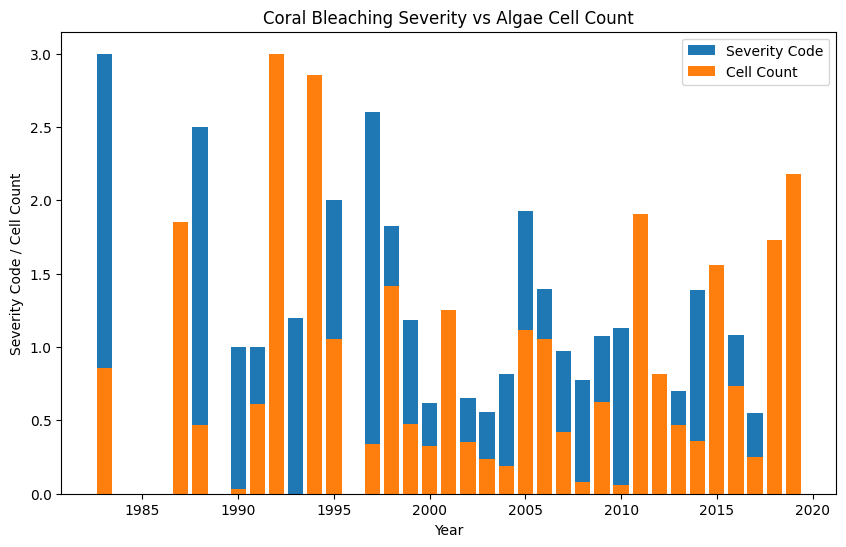

In [24]:
# barchart
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart using the merged data
ax.bar(left_merged['Year'], left_merged['Severity_Code'], label='Severity Code')
ax.bar(left_merged['Year'], left_merged['NORM_CELLCOUNT'], label='Cell Count')

# Set the chart title and axis labels
ax.set_title('Coral Bleaching Severity vs Algae Cell Count')
ax.set_xlabel('Year')
ax.set_ylabel('Severity Code / Cell Count')

# Set the x-axis tick labels to the years
# ax.set_xticklabels(merged_data['Year'])

# Add a legend
ax.legend()

# Show the chart
plt.show()

The Cell count data have been normalized to a scale of 0 - 3, so 0 represents a cell count value of 19400 and 3 represents 2710752.
While the severity codes are from 0 - 3 and 0 being no bleaching observed and 3 being completed bleached coral.

Based off the bar chart prediction can be made that there is some corealtion between the increase in cellcount has an impact on bleaching level.

More research is needed.

#### Severity and fishing data

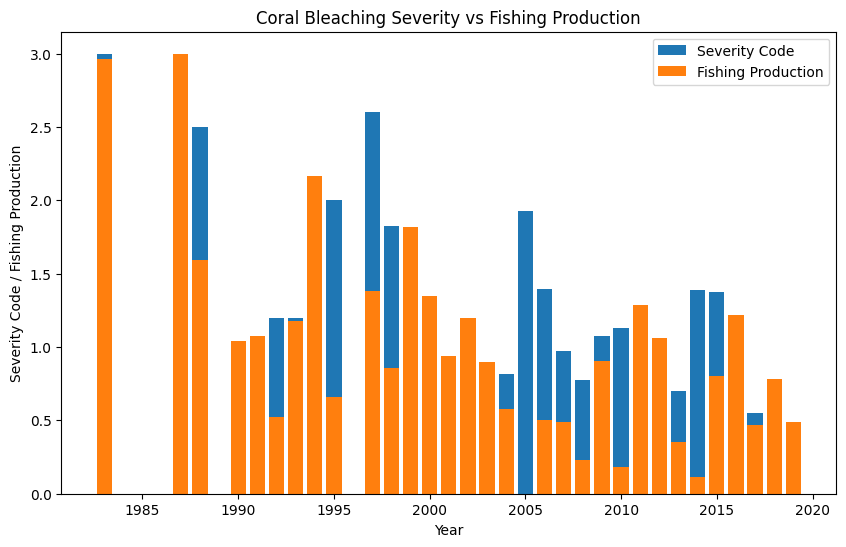

In [25]:
# barchart
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart using the merged data
ax.bar(left_merged['Year'], left_merged['Severity_Code'], label='Severity Code')
ax.bar(left_merged['Year'], left_merged['Norm_Pounds'], label='Fishing Production')

# Set the chart title and axis labels
ax.set_title('Coral Bleaching Severity vs Fishing Production')
ax.set_xlabel('Year')
ax.set_ylabel('Severity Code / Fishing Production')

# Set the x-axis tick labels to the years
# ax.set_xticklabels(merged_data['Year'])

# Add a legend
ax.legend()

# Show the chart
plt.show()

#### Cell Count and Fishing Production

Some corelation can be observed whenever fishing production is increased we see an increase in severity level. Further research is needed.

### Line Plot
Line plot of fishing production, algae cell count, and severity code over time

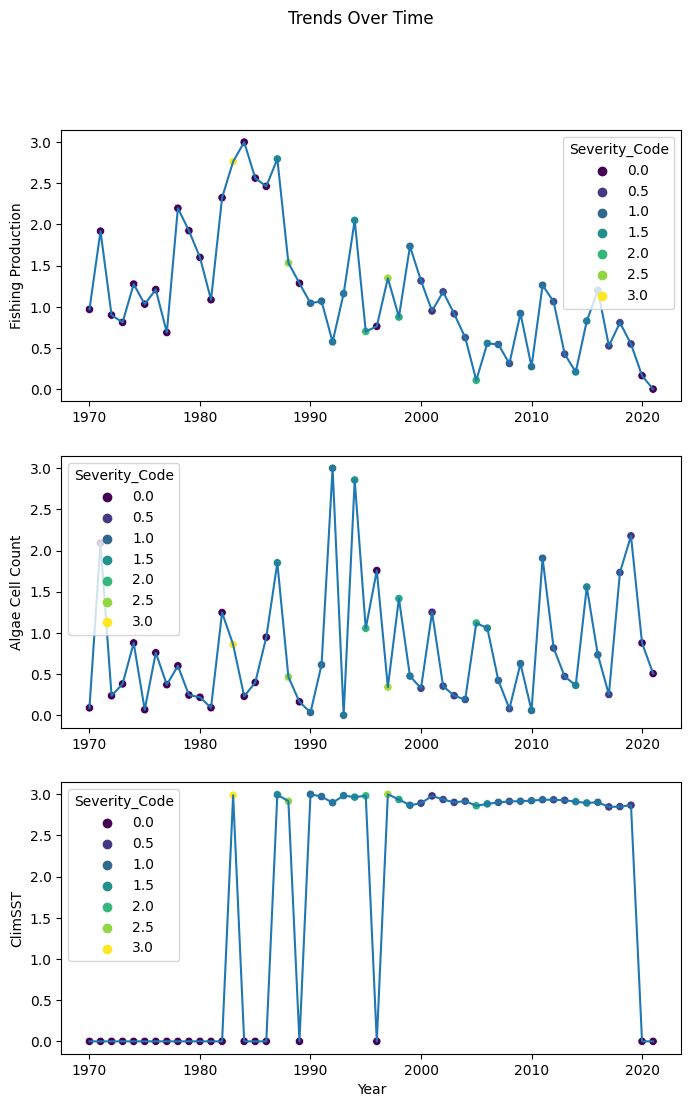

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
sns.lineplot(data=df_merged, x='Year', y='Norm_Pounds', ax=axs[0])
sns.scatterplot(data=df_merged, x='Year', y='Norm_Pounds', hue='Severity_Code', palette='viridis', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Fishing Production')

sns.lineplot(data=df_merged, x='Year', y='NORM_CELLCOUNT', ax=axs[1])
sns.scatterplot(data=df_merged, x='Year', y='NORM_CELLCOUNT', hue='Severity_Code', palette='viridis', ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('Algae Cell Count')

sns.lineplot(data=df_merged, x='Year', y='ClimSST', ax=axs[2])
sns.scatterplot(data=df_merged, x='Year', y='ClimSST', hue='Severity_Code', palette='viridis', ax=axs[2])
axs[2].set_ylabel('ClimSST')

fig.suptitle('Trends Over Time')
plt.show()

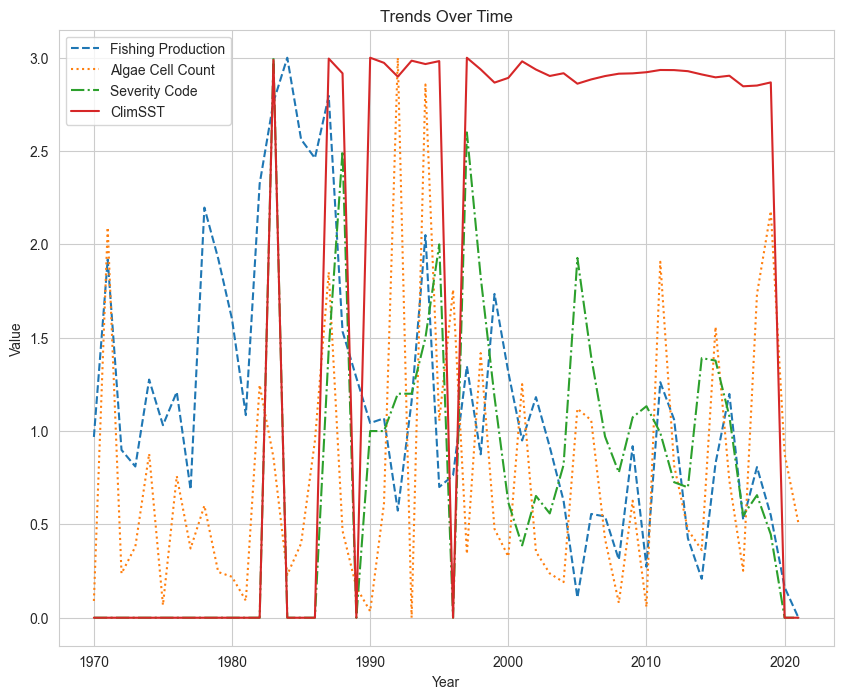

In [27]:
# Line plot of fishing production, algae cell count, and severity code over time
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

sns.lineplot(data=df_merged, x='Year', y='Norm_Pounds', label='Fishing Production', linestyle='--')
sns.lineplot(data=df_merged, x='Year', y='NORM_CELLCOUNT', label='Algae Cell Count', linestyle=':')
sns.lineplot(data=df_merged, x='Year', y='Severity_Code', label='Severity Code', linestyle='-.')
sns.lineplot(data=df_merged, x='Year', y='ClimSST', label='ClimSST', linestyle='-')

plt.title('Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

plt.show()


Corelations can be seen with increase in temperature of the sea, fishing production, algae cell count and bleaching severity levels. Although more research is needed at this point and more data needs to be collected to make any definitive claims.

### Heat Map

/var/folders/38/j50bq1bs56n7k159368_h9140000gn/T/ipykernel_2643/480241394.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_heatmap.corr(), annot=True, square=True, cmap='coolwarm')


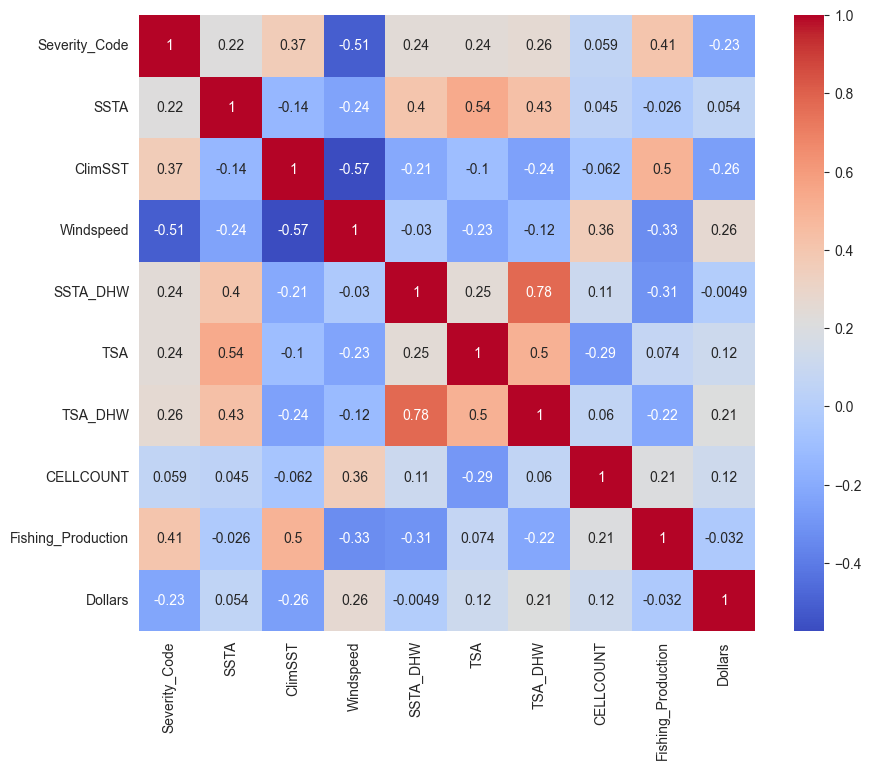

In [28]:
# heatmap data everything from df_merged except for year, NORM_CELLCOUNT, and NORM_POUNDS
df_heatmap = left_merged.drop(['Year', 'NORM_CELLCOUNT', 'Norm_Pounds', 'Metric Tons'], axis=1)
# print(df_heatmap)
# print(df_merged.columns)
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

Based off the heat map and our hypothesis, we can see:

Strong positive correlations:
- Severity code and ClimSST
- Severity code and fishing production
- ClimSST and fishing production

Weak positive correlations:
- Severity code and Cell count

Weak Negative correlation:
- ClimSST and Cell Count


## ML
Kmeans, Lets first decide the cluster size using the elbow method

[11903.314946933482, 3081.0020235363445, 1403.07185092432, 839.6482684995976, 565.272108295058, 420.9665820634594, 331.31135778485805, 268.65959726355896, 227.79086196031517, 199.41004969992645]


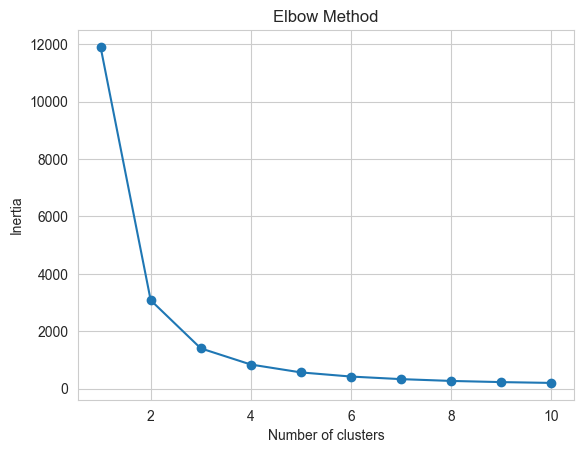

In [29]:
# Define the range of clusters to test
clusters_range = range(1, 11)

# Fit the KMeans model for each cluster value and calculate the inertia
inertia = []
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_merged[['Year', 'ClimSST', 'Norm_Pounds', 'Severity_Code', 'NORM_CELLCOUNT']])
    inertia.append(kmeans.inertia_)

print (inertia)
# Plot the elbow curve
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### Two clusters

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


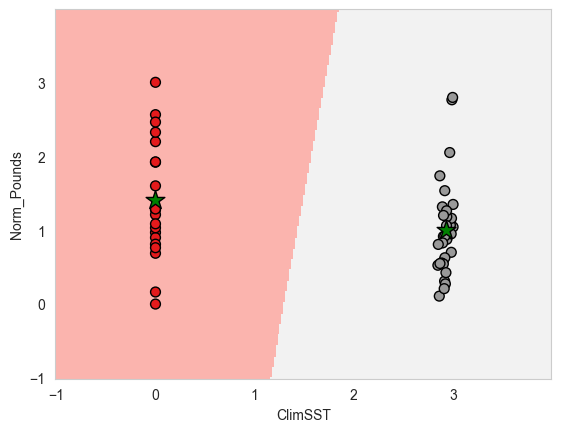

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


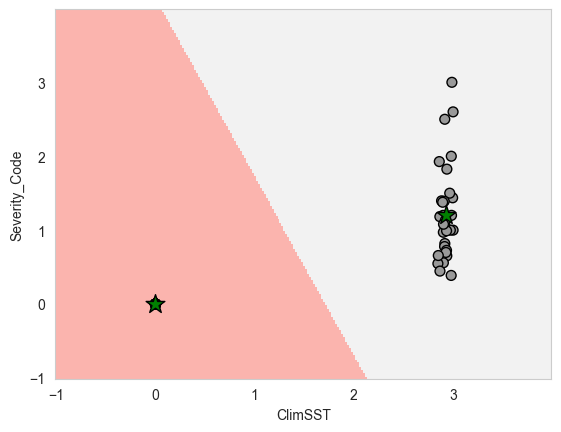

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


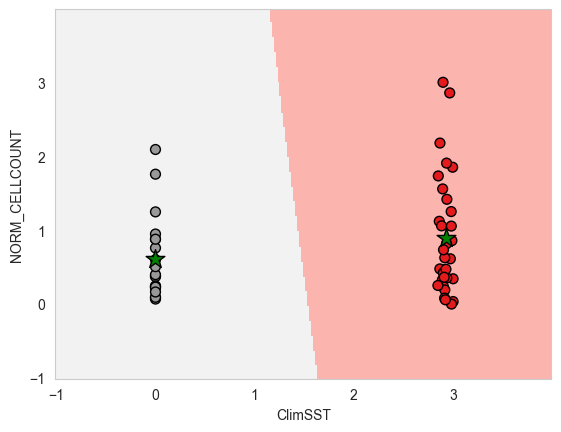

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


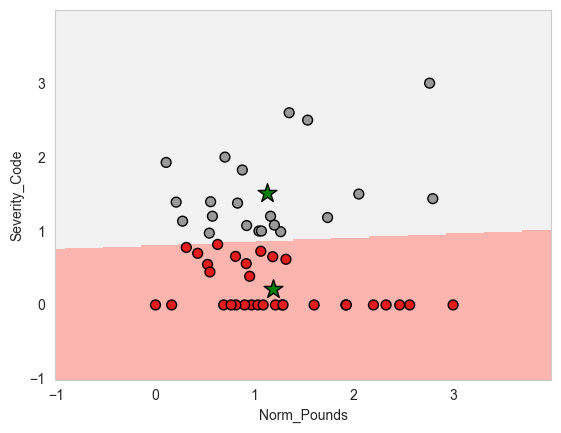

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


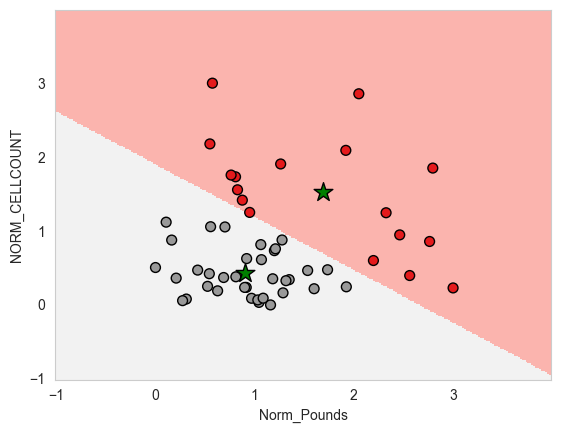

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


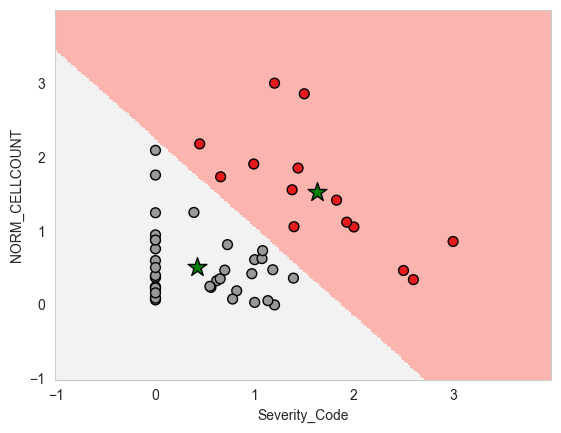

In [30]:
import numpy as np

# meshgrid function from prelab 5
def meshGrid (x , y , h):
    '''x is data for x-axis meshgrid
       y is data for y-axis meshgrid
       h is stepsize
    '''
    x_min, x_max = x.min() - 1 , x.max() + 1
    y_min, y_max = y.min() - 1 , y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return xx , yy

# Define the features to use
features = ['ClimSST', 'Norm_Pounds', 'Severity_Code', 'NORM_CELLCOUNT']

# Define the number of clusters
n_clusters = 2

# Iterate through all combinations of two features
for i in range(len(features)):
    for j in range(i+1, len(features)):
        feat1 = features[i]
        feat2 = features[j]
        
        # Get the data points for the two selected features
        new_merge = df_merged[['Year', feat1, feat2]]
        
        # Run KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(new_merge[[feat1, feat2]])
        
        # Get the cluster labels for each data point
        labels = kmeans.labels_
        
        xx, yy = meshGrid(new_merge[feat1], new_merge[feat2], 0.02)
        Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(new_merge[feat1], new_merge[feat2], c=labels, cmap=plt.cm.Set1, edgecolor='k', s=50)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='green', marker='*', s=200, edgecolor='k')
        plt.xlabel(feat1)
        plt.ylabel(feat2)
        plt.show()

## ML 

Random forest

Features: ['ClimSST', 'CELLCOUNT', 'Fishing_Production']
Random Forest Mean Squared Error: 0.3352980181366332
Random Forest R-squared: 0.13076701358904097


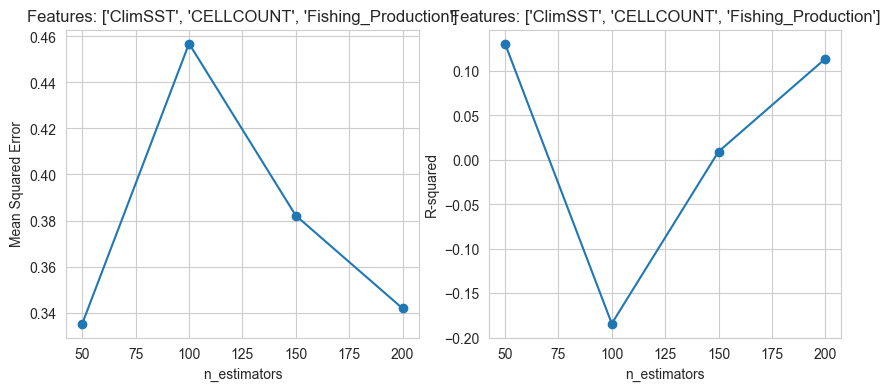

Features: ['ClimSST', 'CELLCOUNT']
Random Forest Mean Squared Error: 0.33443680911582113
Random Forest R-squared: 0.13299962830369005


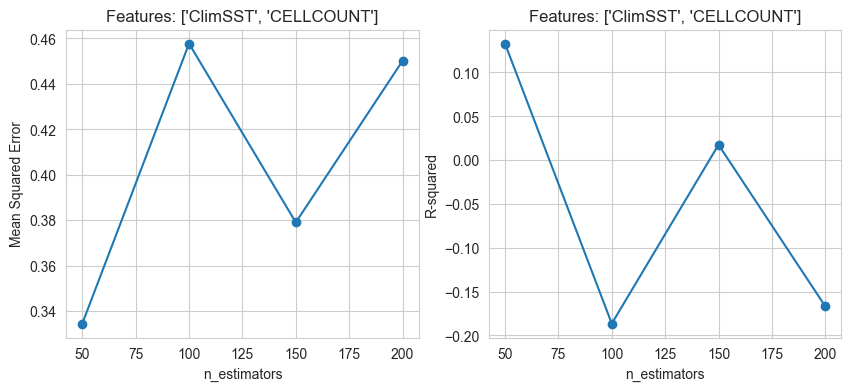

Features: ['ClimSST', 'Fishing_Production']
Random Forest Mean Squared Error: 0.35055091866805366
Random Forest R-squared: 0.09122510292092256


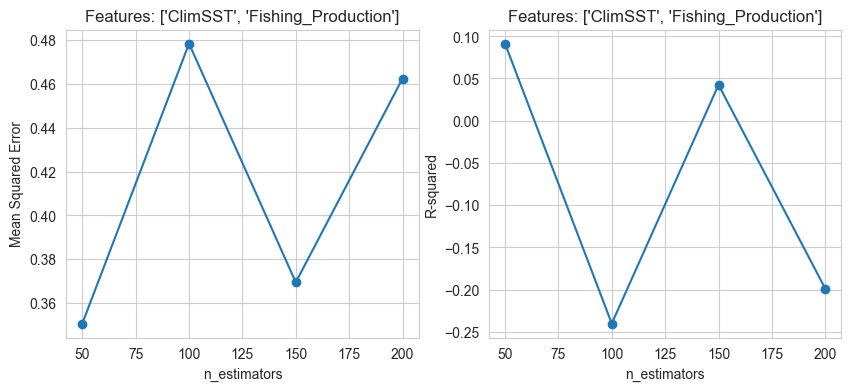

Features: ['CELLCOUNT', 'Fishing_Production']
Random Forest Mean Squared Error: 0.3547912106241538
Random Forest R-squared: 0.08023248906433433


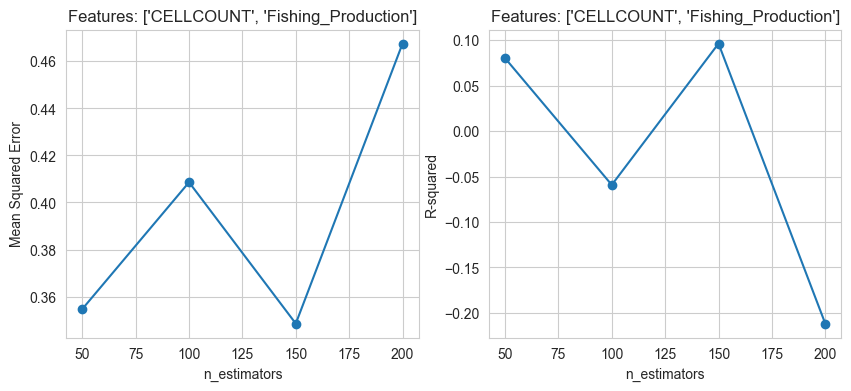

Features: ['ClimSST']
Random Forest Mean Squared Error: 0.4346988186529057
Random Forest R-squared: -0.1269215202250502


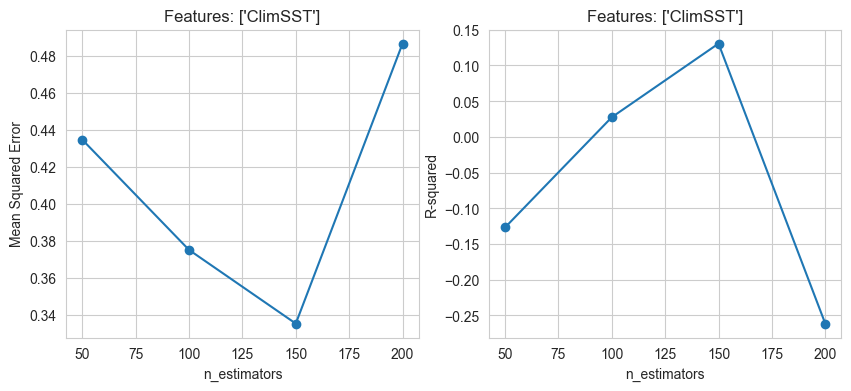

In [34]:
# ML - random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

feature_sets = [    ['ClimSST', 'CELLCOUNT', 'Fishing_Production'],
    ['ClimSST', 'CELLCOUNT'],
    ['ClimSST', 'Fishing_Production'],
    ['CELLCOUNT', 'Fishing_Production'],
    ['ClimSST']
]
mse_values = []
r2_values = []
for features in feature_sets:
    # Assume X is your feature matrix and y is your target variable
    X = df_merged[features]
    y = df_merged['Severity_Code']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for n in [50, 100, 150, 200]:
        # Initialize the model
        rf_model = RandomForestRegressor(n_estimators=n, random_state=42)

        # Fit the model to the training data
        rf_model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = rf_model.predict(X_test)

        # Calculate the R-squared value
        r2 = r2_score(y_test, y_pred)

        # Calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)
        r2_values.append(r2)

n_values = [50, 100, 150, 200]

for i, features in enumerate(feature_sets):
    print(f"Features: {features}")
    print(f"Random Forest Mean Squared Error: {mse_values[i]}")
    print(f"Random Forest R-squared: {r2_values[i]}")   

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the mean squared error
    axs[0].plot(n_values, mse_values[i::len(feature_sets)], '-o')
    axs[0].set_xlabel('n_estimators')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title(f"Features: {features}")

    # Plot the R-squared value
    axs[1].plot(n_values, r2_values[i::len(feature_sets)], '-o')
    axs[1].set_xlabel('n_estimators')
    axs[1].set_ylabel('R-squared')
    axs[1].set_title(f"Features: {features}")

    plt.show()


ClimSST and CellCount seemed to be the best option, however I wanted to further investigate this using the linear model.

## ML
Linear Regression

Linear Regression
Features: ['ClimSST', 'CELLCOUNT', 'Fishing_Production']
Mean Squared Error: 0.2388102921123698
R-squared: 0.38090363745031275
Features: ['ClimSST', 'CELLCOUNT']
Mean Squared Error: 0.16585005396558675
R-squared: 0.5700471523628874
Features: ['ClimSST', 'Fishing_Production']
Mean Squared Error: 0.22716394271444323
R-squared: 0.4110958560748198
Features: ['CELLCOUNT', 'Fishing_Production']
Mean Squared Error: 0.40805552858182814
R-squared: -0.0578509461578367
Features: ['ClimSST']
Mean Squared Error: 0.16739267912186884
R-squared: 0.5660480214435948
Mean Squared Error: 0.16585005396558675
R-squared: 0.5700471523628874


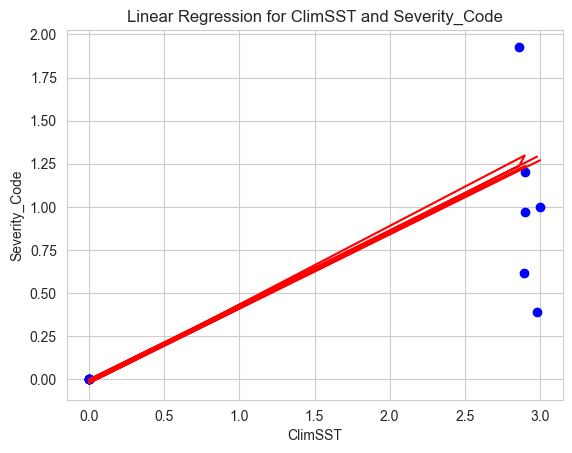

In [32]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define a list of feature sets
feature_sets = [    ['ClimSST', 'CELLCOUNT', 'Fishing_Production'],
    ['ClimSST', 'CELLCOUNT'],
    ['ClimSST', 'Fishing_Production'],
    ['CELLCOUNT', 'Fishing_Production'],
    ['ClimSST']
]

print('Linear Regression')

# Loop through each feature set and run linear regression
for features in feature_sets:
    X = df_merged[features]
    y = df_merged['Severity_Code']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = lr_model.score(X_test, y_test)
    print('Features:', features)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)

# ClimSST and CELLCOUNT has the lowest MSE and highest R-squared value

# most frequent number of Climate SST
# print(df_merged['ClimSST'].value_counts())

# based off the Mean squared error and R-squared values, we will use the features ClimSST and CELLCOUNT
X = df_merged[['ClimSST', 'CELLCOUNT']]
y = df_merged['Severity_Code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = lr_model.score(X_test, y_test)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the data points and the regression line
plt.scatter(X_test['ClimSST'], y_test, color='blue')
plt.plot(X_test['ClimSST'], y_pred, color='red')
plt.xlabel('ClimSST')
plt.ylabel('Severity_Code')
plt.title('Linear Regression for ClimSST and Severity_Code')
plt.show()


## Conclusion:
More research and data is needed to make any definitive claims at this point since the current data doesn't really represent a strong connection/support our hypothesis. In addition, it seems like just by the increase in fishing production doesn't really increase the algae cell count and both these factors doesn't really have a strong connection in the increase of coral reef bleaching (there is some connection just not enough to make any claims at this time). Other environmental factors seem to be factors like Windspeed, SSTA etc (from the heatmap). If further research is done on those factors with a change in hypothesis then we can show some connection. We also discovered the data for fishing, algae cell count and coral bleaching events are a bit limited since the cost to acquire this data is in millions of dollars and researchers aren't funded in this sectors. Most of the data we found are from either limited regions or really old or unaccurate as each researcher seem to collect the data in their own method of calculation. I had to noramlize and use standard scale when cleaning the data and this led to more limited data and had a strong affect on the ML tasks. Most of the above code was a result of several trail and errors of data cleaning, ML tasks and the best options were picked for this project. I tried soem time series analysis and most of them failed because there isn't data to make any predictions after standardtizing and noramlizing the data we acquired.

To conclude, we need to invest more in sectors like marine life preservation as it is an importnat factor to save our environment.